In [31]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalBoosting import MeanFieldVariationalMixtureDistribution
from Tools.NNtools import *

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [33]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [34]:
model = nn.Sequential( nn.Linear(1, 20),
                       nn.Tanh(), 
                       nn.Linear(20, 1),
                     ).to(device)

In [35]:
param_count = get_param(model).shape[0]

In [36]:
flip_parameters_to_tensors(model)

In [37]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [38]:
def logprior(x):
    return prior.log_prob(x)

In [39]:
def loglikelihood(theta, model, x, y, sigma_noise):
    def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [40]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [60]:
def Boost(qC, n_samples_ELBO):
    qC.requires_grad_(False)
    for c in qC.components:
        c.mu.detach_()
        c.rho.detach_()
        
    with torch.no_grad():  
        Ln = []
        for j in range(10000):
            z = q.sample(1)
            LQ = qC.log_prob(z)
            LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
            Ln.append(LQ - LP)
        baseline = torch.stack(Ln).mean()
        Ln = []
    print(baseline)
    
    q_new = MeanFieldVariationalDistribution(param_count, sigma=0.1, device=device)
    unbounded_prop_new = torch.tensor(2.0, device=device).requires_grad_(True)

    q_new.mu = nn.Parameter(prior.sample()[0,:].detach().clone().to(device), requires_grad=True) 

    q_new.rho.requires_grad = True
    q_new.mu.requires_grad = True
    
    optimizer = torch.optim.Adam(list(q_new.parameters())+[unbounded_prop_new], lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

    %matplotlib inline
    liveloss = PlotLosses()
    for t in range(1000):
        logs = {}
        optimizer.zero_grad()

        Ln = []
        for j in range(n_samples_ELBO):
            Xc = qC.sample(1)
            Xnew = q_new.sample(1)
            prop_new = torch.sigmoid(unbounded_prop_new)

            v = -(1-prop_new)*torch.mean(logposterior(Xc, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xc, q_new, unbounded_prop_new)) - \
            prop_new*torch.mean(logposterior(Xnew, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xnew, q_new, unbounded_prop_new))

            Ln.append(v)
            
        L = torch.stack(Ln).mean()
        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        logs['ELBO'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        liveloss.update(logs)

        if t % 10 == 0:
            liveloss.draw()

        optimizer.step()

        if learning_rate < 0.001:
            break

    with torch.no_grad():
        for j in range(1000):
            Xc = qC.sample(1)
            Xnew = q_new.sample(1)
            prop_new = torch.sigmoid(unbounded_prop_new)

            v = -(1-prop_new)*torch.mean(logposterior(Xc, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xc, q_new, unbounded_prop_new)) - \
            prop_new*torch.mean(logposterior(Xnew, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xnew, q_new, unbounded_prop_new))

            Ln.append(v)
            
        score = torch.stack(Ln).mean()
    print(score)
            
    if score < baseline:
        components = qC.components + [q_new]
        proportions = torch.cat([(1-torch.sigmoid(unbounded_prop_new))*qC.proportions, torch.tensor([torch.sigmoid(unbounded_prop_new)],device=device)]).detach()

        qC_new = MeanFieldVariationalMixtureDistribution(proportions, components, device=device)
    else:
        qC_new = qC
    return qC_new

# Variational Distribution #

In [42]:
q = MeanFieldVariationalDistribution(param_count, sigma=0.01, device=device)
q.mu = nn.Parameter(prior.sample()[0,:].detach().clone().to(device), requires_grad=True) 

q.rho.requires_grad = True
q.mu.requires_grad = True

In [43]:
q.mu.detach_().requires_grad_(True)
q.rho.detach_().requires_grad_(True);

In [44]:
n_samples_ELBO = 5

In [45]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

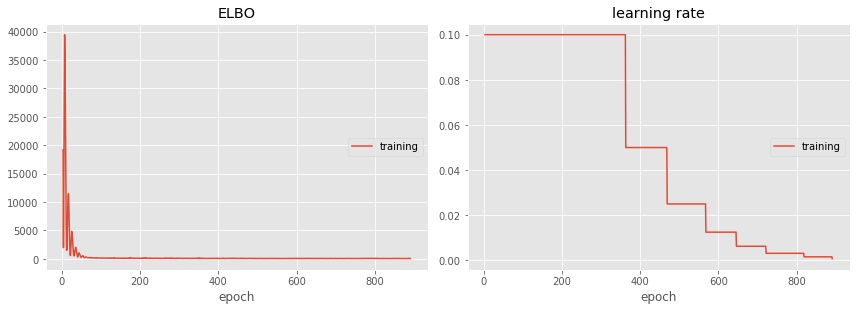

ELBO:
training   (min:   49.012, max: 206309.578, cur:   69.430)

learning rate:
training   (min:    0.001, max:    0.100, cur:    0.001)


In [46]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    Ln = []
    for j in range(n_samples_ELBO):
        z = q.sample(1)
        LQ = q.log_prob(z)
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        Ln.append(LQ - LP)

    L = torch.stack(Ln).mean()
    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.001:
        break

In [48]:
components = [q]
proportions = torch.tensor([1.0], device=device)
qC = MeanFieldVariationalMixtureDistribution(proportions, components, device=device)

In [49]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)

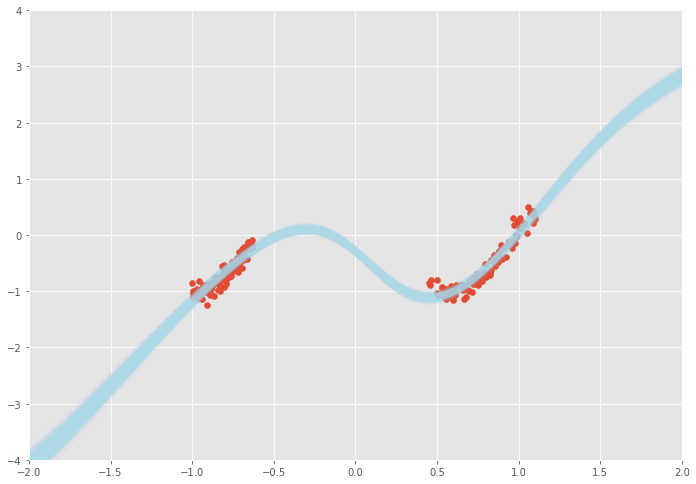

In [54]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = qC.sample()
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [62]:
qC.proportions

tensor([1.], device='cuda:0')

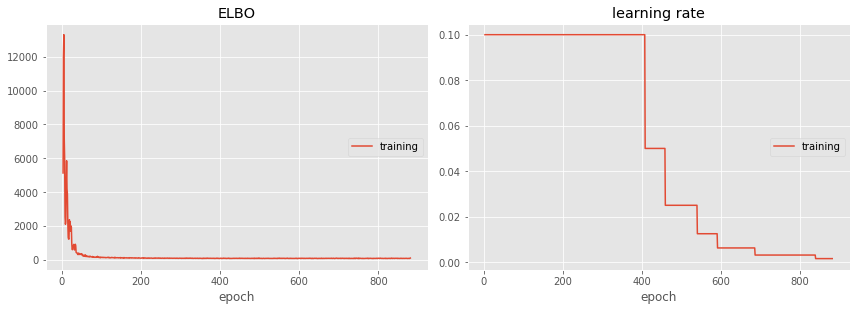

ELBO:
training   (min:   56.923, max: 37420.961, cur:   89.550)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)
tensor(71.7488, device='cuda:0')


In [61]:
qC = Boost(qC, 10)

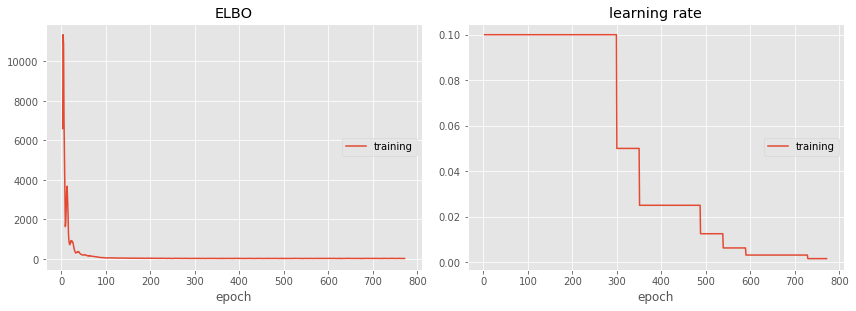

ELBO:
training   (min:   15.629, max: 29046.836, cur:   23.686)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


In [24]:
qC = Boost(qC, 5)

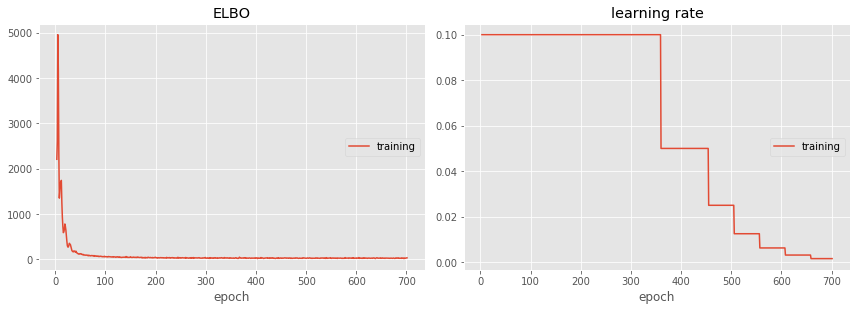

ELBO:
training   (min:   16.671, max: 10198.372, cur:   33.682)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


In [25]:
qC = Boost(qC, 50)

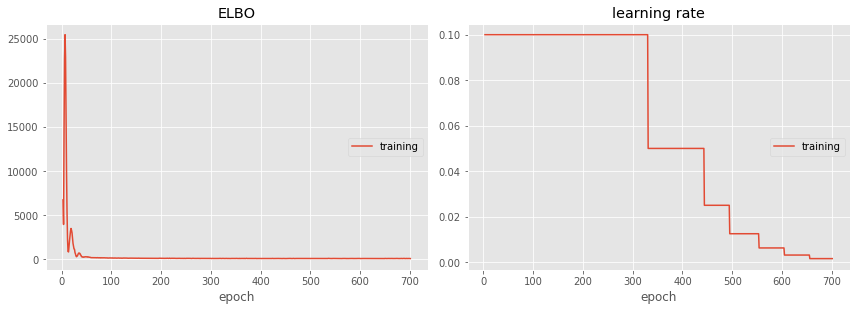

ELBO:
training   (min:   26.914, max: 133602.609, cur:   31.943)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


In [28]:
qC = Boost(qC, 50)

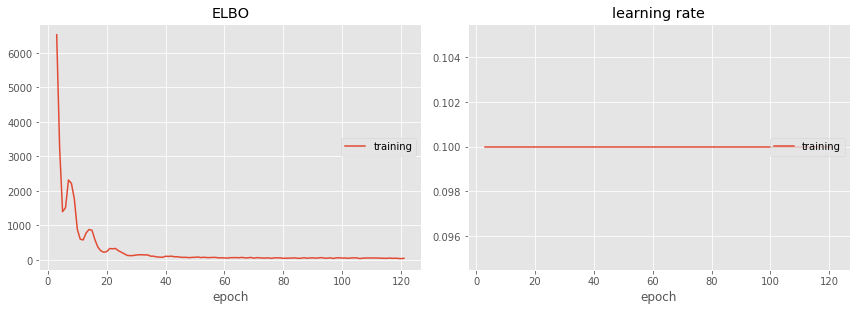

ELBO:
training   (min:   39.471, max: 8119.844, cur:   48.148)

learning rate:
training   (min:    0.100, max:    0.100, cur:    0.100)


KeyboardInterrupt: 

In [30]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 50)

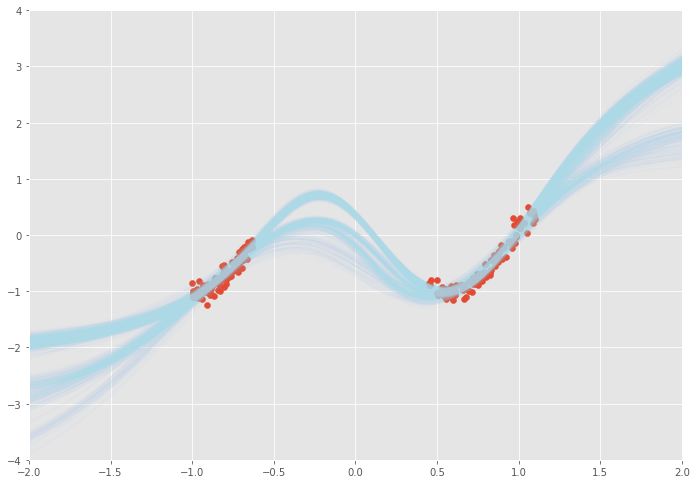

In [29]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = qC.sample()
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')